In this notebook, a simple MLP will try to match a wavefield snapshot generated with Salvus for a simple homogeneous case with the parameters taken from the Moseley paper.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import h5py

In [2]:
# Pytorch Model Name
model_name = 'Cube_Exp.pt'

# Load Salvus data
path = "../NoCrack/Simple_Homogeneous/Event0000/output.h5"
hf = h5py.File(path, 'r')

In [3]:
df_start = pd.DataFrame()
df_start['X'] = hf['coordinates_ACOUSTIC'][:,0][:,0].astype(float)
df_start['Y'] = hf['coordinates_ACOUSTIC'][:,0][:,1].astype(float)
df_start['True'] = hf['volume']['phi'][50][:,0].mean(axis=1)

In [4]:
# Scaling, optional
from sklearn.preprocessing import MinMaxScaler

scaling = False
if scaling:
    scaler = MinMaxScaler()
    df_start[['X','Y','True']] = scaler.fit_transform(df_start[['X','Y','True']])

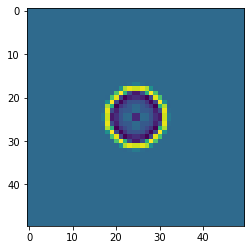

In [5]:
# Pivot Table to reorder the data
df_show = df_start.pivot_table(values='True',index='Y',columns='X').sort_index(axis=0,ascending=False)

# Plot
plt.imshow(df_show.values)

<AxesSubplot:>

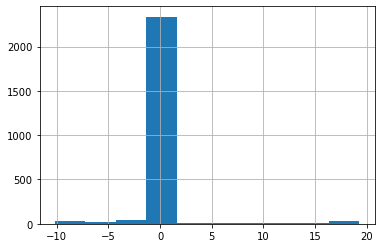

In [6]:
df_start['True'].hist()

In [8]:
import torch
import torch.nn as nn

from model import *

In [13]:
# CUDA support 
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [14]:
def train(model,X_train,y_train,loss_fn,optimizer,epoch):
    model = model.to(device)

    x = torch.tensor(X_train[:, 0:1], requires_grad=True).float().to(device)
    y = torch.tensor(X_train[:, 1:2], requires_grad=True).float().to(device)

    true = torch.tensor(y_train).float().to(device)

    tot_loss = []
    for i in range(epoch):
        model.train()

        optimizer.zero_grad()

        preds = model(torch.cat([x, y], dim=1))

        loss = loss_fn(preds,true)
        loss.backward()
        optimizer.step()

        if i % 2000 == 0:
            print('Iter %d, Loss: %.5e' % (i,loss))

        tot_loss.append(loss)

    model.eval()

    preds = model(torch.cat([x, y], dim=1))
    preds = preds.detach().cpu().numpy()

    return model, preds, tot_loss

In [15]:
def plots(df_data):
    # Compute error :
    df_data['Error'] = df_data['Preds']-df_data['True']

    # Plot :
    fig, ax = plt.subplots(1,3,figsize=(16,4))

    im = ax[0].imshow(df_data.pivot_table(values='Preds',index='Y',columns='X').sort_index(axis=0,ascending=False))
    ax[0].set_title('Prediction')
    fig.colorbar(im, ax=ax[0])

    im = ax[1].imshow(df_data.pivot_table(values='True',index='Y',columns='X').sort_index(axis=0,ascending=False))
    ax[1].set_title('True')
    fig.colorbar(im, ax=ax[1])

    im = ax[2].imshow(df_data.pivot_table(values='Error',index='Y',columns='X').sort_index(axis=0,ascending=False))
    ax[2].set_title('Error')
    fig.colorbar(im, ax=ax[2])

    plt.show()

In [19]:
model = Model(in_size=2)

loss_fn = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(),lr = 0.001)

X_train = df_start.loc[:,['X','Y']].values
y_train = df_start.loc[:,['True']].values

In [20]:
epoch = 100000
model_trained_start, preds_start, loss_start = train(model,X_train,y_train,loss_fn,optimizer,epoch)

Iter 0, Loss: 6.56852e+00
Iter 2000, Loss: 5.07479e+00
Iter 4000, Loss: 1.28478e+00
Iter 6000, Loss: 6.00421e-01
Iter 8000, Loss: 4.18820e-01
Iter 10000, Loss: 3.31889e-01
Iter 12000, Loss: 2.74643e-01
Iter 14000, Loss: 2.35287e-01
Iter 16000, Loss: 2.07614e-01
Iter 18000, Loss: 1.86670e-01
Iter 20000, Loss: 1.70916e-01
Iter 22000, Loss: 1.60041e-01
Iter 24000, Loss: 1.51372e-01
Iter 26000, Loss: 1.44556e-01
Iter 28000, Loss: 1.39206e-01
Iter 30000, Loss: 1.39351e-01
Iter 32000, Loss: 1.31046e-01
Iter 34000, Loss: 1.27783e-01
Iter 36000, Loss: 1.25167e-01
Iter 38000, Loss: 1.22844e-01
Iter 40000, Loss: 1.20809e-01
Iter 42000, Loss: 1.18925e-01
Iter 44000, Loss: 1.17504e-01
Iter 46000, Loss: 1.16291e-01
Iter 48000, Loss: 1.13915e-01
Iter 50000, Loss: 1.12256e-01
Iter 52000, Loss: 1.10505e-01
Iter 54000, Loss: 1.09736e-01
Iter 56000, Loss: 1.06943e-01
Iter 58000, Loss: 1.05468e-01
Iter 60000, Loss: 1.04225e-01
Iter 62000, Loss: 1.02917e-01
Iter 64000, Loss: 1.01734e-01
Iter 66000, Loss: 

In [21]:
df_start['Preds'] = preds_start

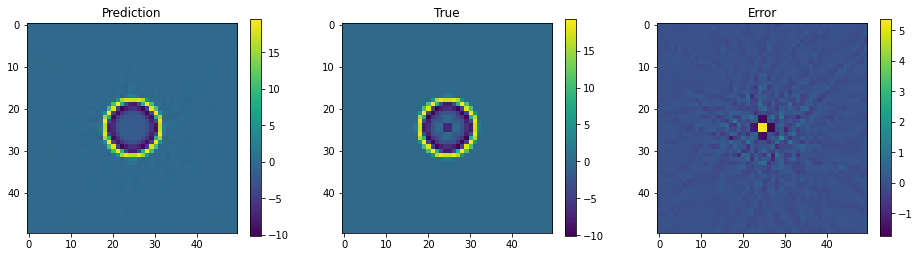

In [22]:
plots(df_start)

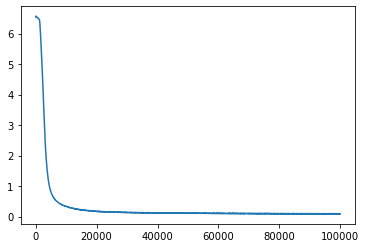

In [23]:
plt.plot(loss_start)

In [24]:
# Save model to reuse it later
PATH = model_name

torch.save(model_trained_start.state_dict(), PATH)

In [26]:
# Load model
model_test = Model(in_size=2)
model_test.load_state_dict(torch.load(PATH))
model_test.eval()

Model(
  (layers): ModuleList(
    (0): Linear(in_features=2, out_features=100, bias=True)
    (1): Linear(in_features=100, out_features=100, bias=True)
  )
  (out): Linear(in_features=100, out_features=1, bias=True)
  (tanh): Tanh()
)